In [2]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 27.7 MB/s 
     |████████████████████████████████| 6.3 MB 64.6 MB/s 
     |████████████████████████████████| 16.7 MB 54.7 MB/s 


In [25]:
pip install mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import datetime
import io
import PIL

from tqdm import trange, tqdm

In [9]:
def clean_text(a_string): return a_string.replace("\t", "")

def change_format(a_string):
    if len(a_string) == 1: return "0"+a_string
    else: return a_string

def to_date_obj(a_string):
    d, m, y = a_string.split("/")
    d = change_format(d); m = change_format(m)
    date_str = d+m+y

    format_str = '%d%m%Y' # The format
    datetime_obj = datetime.datetime.strptime(date_str, format_str)
    return datetime_obj.date()

In [10]:
tha_map = gpd.read_file("/content/drive/MyDrive/DS/dataCovid/THA_MAP.shp")
provice_name = pd.read_csv("/content/drive/MyDrive/DS/dataCovid/Province_NAME.csv", index_col=None); del provice_name["Index"]
provice_name["NAME"] = provice_name["NAME"].apply(clean_text)

tha_map["NAME"] = provice_name["NAME"]
tha_map["Province"] = provice_name["Province"]
tha_map = tha_map.sort_values(by="NAME")

del provice_name

In [11]:
tha_map.head()

,geometry,NAME,Province
17,"MULTIPOLYGON (((99.11329 7.48927, 99.11337 7.4...",กระบี่,Krabi
2,"POLYGON ((100.61389 13.95462, 100.61428 13.954...",กรุงเทพมหานคร,Bangkok
15,"POLYGON ((98.58631 15.65465, 98.58662 15.65384...",กาญจนบุรี,Kanchanaburi
13,"POLYGON ((103.58404 17.09981, 103.58452 17.099...",กาฬสินธุ์,Kalasin
14,"POLYGON ((99.48875 16.91044, 99.48883 16.91016...",กำแพงเพชร,Kamphaeng Phet


In [35]:
cv_cases = pd.read_csv("/content/drive/MyDrive/DS/dataCovid/confirmed-cases-data.csv")
cv_cases = cv_cases.dropna()
cv_cases["announce_date"] = cv_cases["announce_date"].apply(to_date_obj)
cv_cases.head()

,announce_date,province_of_onset,case
0,2020-01-12,กรุงเทพมหานคร,1.0
1,2020-01-17,กรุงเทพมหานคร,1.0
2,2020-01-22,นครปฐม,1.0
3,2020-01-22,กรุงเทพมหานคร,1.0
4,2020-01-24,กรุงเทพมหานคร,1.0


In [36]:
all_dates = sorted(list(set(cv_cases.announce_date)))
pvs = sorted(list(set(cv_cases.province_of_onset.values)))

In [37]:
# Ensure the same provinces
tmp = sorted(list(set(tha_map.NAME.values)))
for i, e in enumerate(sorted(list(set(tha_map.NAME.values)))):
    if e != tmp[i]: print(e)
del tmp

In [38]:
bkk = pvs[1]
bkk

'กรุงเทพมหานคร'

In [39]:
bkk_cv_cases = cv_cases[cv_cases.province_of_onset == bkk]
bkk_cv_cases = bkk_cv_cases.groupby(["announce_date"], as_index=False).sum()
bkk_cv_cases = bkk_cv_cases.sort_values(by="announce_date")
bkk_cv_cases.head()

,announce_date,case
0,2020-01-12,1.0
1,2020-01-17,1.0
2,2020-01-22,1.0
3,2020-01-24,1.0
4,2020-01-25,1.0


In [40]:
init = [0 for i in range(len(all_dates))]
for i, d in enumerate(all_dates):
    case = bkk_cv_cases[bkk_cv_cases.announce_date==d]["case"].values
    if len(case) > 0: init[i] = case[0]

In [41]:
rows = []
for province in pvs:
    province_cv_cases = cv_cases[cv_cases.province_of_onset == province]
    province_cv_cases = province_cv_cases.groupby(["announce_date"], as_index=False).sum()
    province_cv_cases = province_cv_cases.sort_values(by="announce_date")
    init = [0 for i in range(len(all_dates))]
    for i, d in enumerate(all_dates):
        case = province_cv_cases[province_cv_cases.announce_date==d]["case"].values
        if len(case) > 0: init[i] = case[0]
    rows.append(init)

In [42]:
rows = np.array(rows, dtype=np.int32)

In [43]:
new_cv_cases = pd.DataFrame(rows, columns=list(map(str, all_dates)))
new_cv_cases["index"] = pvs
new_cv_cases["index"] = new_cv_cases["index"].astype(str)

In [44]:
new_cv_cases.reset_index(inplace=False)
new_cv_cases.head()

,2020-01-12,2020-01-17,2020-01-22,2020-01-24,2020-01-25,2020-01-26,2020-01-28,2020-01-31,2020-02-04,2020-02-08,...,2021-07-01,2021-07-02,2021-07-03,2021-07-04,2021-07-05,2021-07-06,2021-07-07,2021-07-08,2021-07-09,index
0,0,0,0,0,0,0,0,0,1,0,...,2,7,2,16,11,6,78,85,32,กระบี่
1,1,1,1,1,1,1,4,4,3,3,...,1860,2208,1962,1582,1871,1520,1647,2324,3061,กรุงเทพมหานคร
2,0,0,0,0,0,0,0,0,0,0,...,19,20,9,17,28,19,23,32,25,กาญจนบุรี
3,0,0,0,0,0,0,0,0,0,0,...,10,14,33,23,6,14,23,22,25,กาฬสินธุ์
4,0,0,0,0,0,0,0,0,0,0,...,4,14,12,21,29,11,17,39,41,กำแพงเพชร


In [45]:
tha_map["NAME"] = tha_map["NAME"].astype(str)
tha_map = tha_map.reset_index()
tha_map = tha_map[["geometry", "NAME"]]
tha_map.head()

,geometry,NAME
0,"MULTIPOLYGON (((99.11329 7.48927, 99.11337 7.4...",กระบี่
1,"POLYGON ((100.61389 13.95462, 100.61428 13.954...",กรุงเทพมหานคร
2,"POLYGON ((98.58631 15.65465, 98.58662 15.65384...",กาญจนบุรี
3,"POLYGON ((103.58404 17.09981, 103.58452 17.099...",กาฬสินธุ์
4,"POLYGON ((99.48875 16.91044, 99.48883 16.91016...",กำแพงเพชร


In [46]:
merge = tha_map.join(new_cv_cases, how="right")
del merge["index"]

0

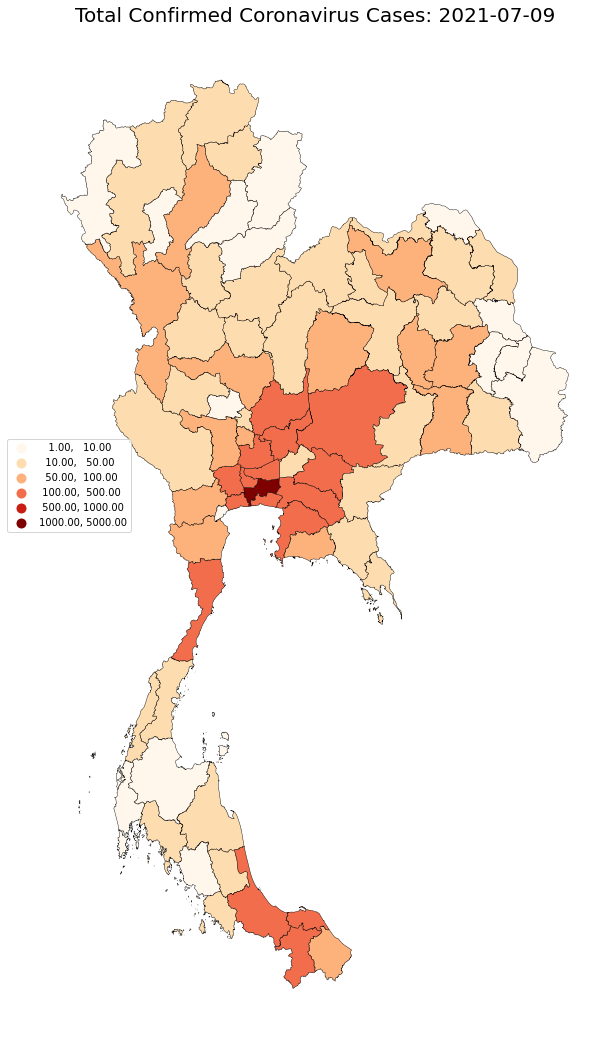

In [47]:
# Plot
bins = [10, 50, 100, 500, 1000, 5000]
test_date = "2021-07-09"
ax = merge.plot(column = test_date, 
                cmap = 'OrRd',
                figsize = (10, 20),
                legend = True,
                scheme = 'user_defined',
                classification_kwds = {'bins':bins},
                edgecolor = 'black',
                linewidth = 0.4)

# Add a title to the map 
ax.set_title('Total Confirmed Coronavirus Cases: '+ test_date, fontdict = 
             {'fontsize':20}, pad = 12.5)

# Removing the axes
ax.set_axis_off()

# Move the legend 
ax.get_legend().set_bbox_to_anchor((0.18, 0.6))

img = ax.get_figure()

f = io.BytesIO()
img.savefig(f, format = 'png', bbox_inches = 'tight')
f.seek(0)